# SCOREO / SIMULACION

A partir de esta versión de la notebook de simulacion (v3) el foco de la muestra es únicamente de "alta presencia". Se compone de los Grupos 1, 2, 3 y 4, los cuales son los grupos que contienen los marca-modelo con suficiente muestra como para cotizarlo mediante el modelo. Los autos que no entren en esta categoría los cotizaremos mediante reglas duras o pasandolos directamente al equipo de Pricing

## Librerías y configuraciones de la notebook

In [1]:
##### Librerías y modulos #######
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings
import openpyxl
import random
import os,json
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()),'src/'))
from funcs_cotizador import *

In [2]:
####### Configuraciones de la notebook (a gusto del usuario) ##########
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# warnings
warnings.filterwarnings("ignore")

In [3]:
#### Parametros de la notebook ####
path_save = '../datos/'
path_model = '../model/'

In [4]:
####### requierments ###########
#!pip install pandas-gbq

In [7]:
# Importar tabla OOT de Big Query
df_scoreo_oot = gbq.read_gbq("SELECT * FROM `data-team-k.pricing_data.match_meli_ok` WHERE date >= '2022-04-18' ", project_id="data-team-k")

In [8]:
df_scoreo_oot.head()

,runtime,date,timestamp,date_hour,price_symbol,price_amount_txt,price_amount,car_year,car_kms_txt,car_kms,...,match_marca_c,score_marca_c,match_modelo_c,score_modelo_c,match_v1_c,score_v1_c,total_score_c,Seg_c,Subseg_c,gama_c
0,2022-04-18 15:00:36.803742+00:00,2022-04-18,2022-04-18 15:01:31.350006+00:00,NaT,U$S,95.000,95000.0000,2021,0 Km,0.0000,...,DS,100,DS,0,7 CROSSBACK HDI 180 AUTOMATIC GRAND CHIC MY20,86,0.0000,Gama Pequenos,Gama Pequenos Premium,Gama Alta
1,2022-04-18 00:00:24.409812+00:00,2022-04-18,2022-04-18 00:03:49.847336+00:00,NaT,$,6.800.000,6800000.0000,2018,20.000 Km,20000.0000,...,TOYOTA,100,86,100,FT M/T,67,67.0000,Gama Medianos,Gama Medianos Premium,Gama Alta
2,2022-04-18 16:00:37.636202+00:00,2022-04-18,2022-04-18 16:02:56.145588+00:00,NaT,U$S,28.900,28900.0000,2013,65.000 Km,65000.0000,...,TOYOTA,100,86,100,FT M/T,67,67.0000,Gama Medianos,Gama Medianos Premium,Gama Alta
3,2022-04-18 16:00:37.636202+00:00,2022-04-18,2022-04-18 16:02:59.056554+00:00,NaT,U$S,26.500,26500.0000,2013,14.423 Km,14423.0000,...,TOYOTA,100,86,100,FT M/T,67,67.0000,Gama Medianos,Gama Medianos Premium,Gama Alta
4,2022-04-18 17:01:07.610504+00:00,2022-04-18,2022-04-18 17:02:26.548752+00:00,NaT,U$S,26.000,26000.0000,2015,24.700 Km,24700.0000,...,TOYOTA,100,86,100,FT M/T,67,67.0000,Gama Medianos,Gama Medianos Premium,Gama Alta


In [9]:
df_scoreo_oot.shape

(99899, 42)

In [11]:
# checkpoint upload
df_scoreo_oot.to_csv('{}df_score_oot_checkpoint.csv'.format(path_save))

In [12]:
# checkpoint upload
#df_scoreo_oot = pd.read_csv('{}df_score_oot_checkpoint.csv'.format(path_save))

In [13]:
# chequeo
print(len(df_scoreo_oot))
print(df_scoreo_oot.date.min(), df_scoreo_oot.date.max())

99899
2022-04-18 00:00:00 2022-04-18 00:00:00


## *Seteo de parametros de la notebook*

In [14]:
# Semilla para el .sample()
seed = random.randint(10,500)

## 1) Pre procesing

In [15]:
# primer tratamiento (incluye todo menos el tratamiento de outliers por contexto)
df_scoreo_oot = data_cleaning_valset(df_scoreo_oot)

Hey! 0 were removed due to null values
Hey! 11769 were removed due to duplicate values
Hey! 695 were removed due those 11111 or 9999 strange values
Hey! 48224 were removed due to 0km or concesioarias
Hey! 8348 were removed due to match scores under 50%
Hey! 0 were removed due to last 15d filter
Hey! 325 were removed due to outliers globales
Hey! 4861 were removed due to categories in which we are not interested in score


In [16]:
df_scoreo_oot.shape

(25677, 12)

In [17]:
df_scoreo_oot.dtypes

runtime           datetime64[ns]
car_id                    object
car_year                   int64
car_kms                    int64
match_marca_a             object
match_modelo_a            object
match_v1_a                object
Subseg_a                  object
Seg_a                     object
price_meli_ok            float64
car_location_1            object
match_v1_c                object
dtype: object

In [18]:
# segundo tratamiento (incluye unicamente el tratamiento de outliers por contexto)
df_scoreo_oot = data_processing_1(df_scoreo_oot,path_save)

Hey! 354 were removed from df due to outliers under context


## 2) Chequeo de nulls

In [19]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [20]:
# chequeamos que no haya nulls
# debido a que no hay ninguna imputacion de nulos en las funciones de procesamiento, si aparecen nulos aca el predict va a romper
# Es por eso que si aparecen, los dropeamos en la proxima celda
df_scoreo_oot.isnull().sum()

runtime           0
car_id            0
car_year          0
car_kms           0
match_marca_a     0
match_modelo_a    0
match_v1_a        0
Subseg_a          0
Seg_a             0
price_meli_ok     0
car_location_1    2
match_v1_c        0
dtype: int64

In [21]:
# Eliminamos los registros con nulos
for col in model_features:
    df_scoreo_oot_final = df_scoreo_oot[~df_scoreo_oot[col].isnull()]

In [22]:
df_scoreo_oot_final.shape

(25323, 12)

## 3) Seleccion muestra final (50 casos)

In [25]:
# Seleccion final de la muestra de 50 registros
df_oot_final_sample = df_scoreo_oot_final.sample(n=50, random_state=seed) 
df_oot_final_sample

,runtime,car_id,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,car_location_1,match_v1_c
26806,2022-04-18 14:00:26,1127904635,2016.0000,87000,HONDA,HR-V,1.8 i-VTEC EX-L CVT 2WD (140cv),Suv Compactas 4x2,SUV,4200000.0000,Capital Federal,EX CVT
15122,2022-04-18 09:00:27,1129495602,2011.0000,150000,HONDA,Fit,1.5 EX CVT IVTEC (120cv) (L18),Monovolumen Compacto,Monovolumen,1450000.0000,Capital Federal,EX
7627,2022-04-18 19:00:31,1131574629,2015.0000,58000,PEUGEOT,208,1.5 N 8v Active (90cv),Gama Pequenos Hatchback,Gama Pequenos,1750000.0000,Córdoba,ACTIVE 1.5 N
44921,2022-04-18 05:00:35,1132272809,2017.0000,75000,FIAT,Siena,EL 1.4 Pack Attractive Seguridad / Emotion (L10),Gama Pequenos Sedan,Gama Pequenos,1600000.0000,Bs.As. G.B.A. Norte,1.4
13107,2022-04-18 16:01:09,1132514020,2014.0000,34000,PEUGEOT,408,Allure 2.0 MT (143cv) 4Ptas.,Gama Pequenos Sedan,Gama Pequenos,2050000.0000,Tucumán,ALLURE 2.0
36039,2022-04-18 17:00:49,1130953285,2015.0000,144000,TOYOTA,Etios,1.5 XLS AT (105cv) (L18) 4Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1850000.0000,Bs.As. G.B.A. Sur,XLS 1.5 M/T
22044,2022-04-18 07:00:32,1126716372,2012.0000,156000,PEUGEOT,3008,1.6T Premium Plus Tiptronic(163cv),SUV 4X2,SUV,2100000.0000,Bs.As. G.B.A. Norte,1.6 THP
57098,2022-04-18 21:00:42,1130176852,2009.0000,168471,FORD,Fiesta,Max 4Ptas. 1.6 N Ambiente Plus MP3 (98cv) (L11),Gama Pequenos Hatchback,Gama Pequenos,1050000.0000,Bs.As. G.B.A. Norte,1.1
71663,2022-04-18 12:00:35,1131574618,2014.0000,110200,TOYOTA,Corolla,XEI 1.8 AT (136cv) (L12),Gama Pequenos Hatchback,Gama Pequenos,2900000.0000,Bs.As. G.B.A. Norte,XEI
11739,2022-04-18 21:00:47,1126717561,2013.0000,90000,PEUGEOT,308,GTI 5Ptas. 1.6 THP 6MT (200cv),Gama Pequenos Hatchback,Gama Pequenos,2300000.0000,Bs.As. G.B.A. Norte,1.6


In [26]:
# nos quedamos solo con las features que usamos en el entrenamiento del modelo para hacer el predict del modelo
X_oot = df_oot_final_sample[model_features].copy()

## 4) Scoreo de la muestra final

In [27]:
# Paso 1: Levantamos el modelo ya entrenado en la notebook anterior
import pickle
with open('{}model_catboost_v4.pickle'.format(path_model), 'rb') as f:
    model = pickle.load(f)

In [28]:
# Paso 2: predict sobre la data nueva
pred = model.predict(X_oot)

In [29]:
type(pred)

numpy.ndarray

In [30]:
len(pred)

50

## 5) Armado del output final

In [31]:
# Precio promedio en MELI
grouped = df_scoreo_oot_final.groupby(['match_marca_a','match_modelo_a','match_v1_a','car_year'], as_index=False)['price_meli_ok'].mean()
grouped.rename(columns={'price_meli_ok':'precio_prom_meli'},inplace=True)
df_oot_final_sample = df_oot_final_sample.merge(grouped, how='inner', on=['match_marca_a','match_modelo_a','match_v1_a','car_year'])

In [32]:
df_oot_final_sample['precio_estimado'] = pred

In [33]:
df_oot_final_sample['precio_estimado'] = df_oot_final_sample['precio_estimado'].astype('int64')
df_oot_final_sample['precio_prom_meli'] = df_oot_final_sample['precio_prom_meli'].astype('int64')

In [34]:
from datetime import datetime
df_oot_final_sample['fecha_simulacion'] = datetime.today().strftime('%Y-%m-%d')

In [35]:
df_oot_final_sample.columns

Index(['runtime', 'car_id', 'car_year', 'car_kms', 'match_marca_a',
       'match_modelo_a', 'match_v1_a', 'Subseg_a', 'Seg_a', 'price_meli_ok',
       'car_location_1', 'match_v1_c', 'precio_prom_meli', 'precio_estimado',
       'fecha_simulacion'],
      dtype='object')

In [36]:
# Ordenamos las columnas de forma prolija
df_oot_final_sample = df_oot_final_sample[['car_id','match_marca_a','match_modelo_a','match_v1_a','match_v1_c'
                                                         ,'car_year','car_kms','Seg_a','Subseg_a','car_location_1'
                                                         ,'precio_estimado','precio_prom_meli','price_meli_ok','fecha_simulacion']]
df_oot_final_sample.rename(columns={'price_meli_ok':'precio_real'},inplace=True)
df_oot_final_sample['precio_real'] = df_oot_final_sample['precio_real'].astype('int64')

In [37]:
# chequeo
df_oot_final_sample.head()

,car_id,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,car_year,car_kms,Seg_a,Subseg_a,car_location_1,precio_estimado,precio_prom_meli,precio_real,fecha_simulacion
0,1127904635,HONDA,HR-V,1.8 i-VTEC EX-L CVT 2WD (140cv),EX CVT,2016.0000,87000,SUV,Suv Compactas 4x2,Capital Federal,4193164,4224515,4200000,2022-04-19
1,1129495602,HONDA,Fit,1.5 EX CVT IVTEC (120cv) (L18),EX,2011.0000,150000,Monovolumen,Monovolumen Compacto,Capital Federal,1828333,1851538,1450000,2022-04-19
2,1131574629,PEUGEOT,208,1.5 N 8v Active (90cv),ACTIVE 1.5 N,2015.0000,58000,Gama Pequenos,Gama Pequenos Hatchback,Córdoba,1959583,1882269,1750000,2022-04-19
3,1132272809,FIAT,Siena,EL 1.4 Pack Attractive Seguridad / Emotion (L10),1.4,2017.0000,75000,Gama Pequenos,Gama Pequenos Sedan,Bs.As. G.B.A. Norte,1769539,1521500,1600000,2022-04-19
4,1132514020,PEUGEOT,408,Allure 2.0 MT (143cv) 4Ptas.,ALLURE 2.0,2014.0000,34000,Gama Pequenos,Gama Pequenos Sedan,Tucumán,2116359,1920000,2050000,2022-04-19


In [38]:
# chequeo
df_oot_final_sample.precio_estimado.describe()

count        50.0000
mean    2911301.1200
std     1908339.2697
min      924800.0000
25%     1779015.2500
50%     2113490.0000
75%     3343485.2500
max     8864392.0000
Name: precio_estimado, dtype: float64

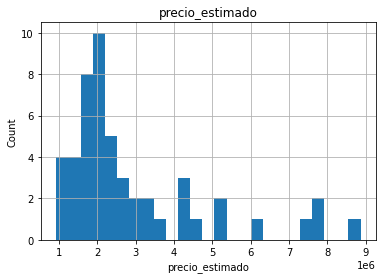

In [39]:
# chequeo
# Distribucion del target
df_oot_final_sample['precio_estimado'].hist(bins=25)
plt.xlabel('precio_estimado')
plt.ylabel("Count")
plt.title('precio_estimado')
plt.show()

In [40]:
df_oot_final_sample.shape

(50, 14)

**Chequeamos R2 y RMSE para la simulacion**

In [41]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(df_oot_final_sample.precio_real, df_oot_final_sample.precio_estimado)

Test set evaluation:
_____________________________________
MAE: 209263.6
MAPE: 7.926366622303173
MEDAPE: 6.272210962566844
MSE: 75510284172.92
RMSE: 274791.34661215224
R2 Square 0.9793655174871544
__________________________________


In [42]:
df_oot_final_sample

,car_id,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,car_year,car_kms,Seg_a,Subseg_a,car_location_1,precio_estimado,precio_prom_meli,precio_real,fecha_simulacion
0,1127904635,HONDA,HR-V,1.8 i-VTEC EX-L CVT 2WD (140cv),EX CVT,2016.0000,87000,SUV,Suv Compactas 4x2,Capital Federal,4193164,4224515,4200000,2022-04-19
1,1129495602,HONDA,Fit,1.5 EX CVT IVTEC (120cv) (L18),EX,2011.0000,150000,Monovolumen,Monovolumen Compacto,Capital Federal,1828333,1851538,1450000,2022-04-19
2,1131574629,PEUGEOT,208,1.5 N 8v Active (90cv),ACTIVE 1.5 N,2015.0000,58000,Gama Pequenos,Gama Pequenos Hatchback,Córdoba,1959583,1882269,1750000,2022-04-19
3,1132272809,FIAT,Siena,EL 1.4 Pack Attractive Seguridad / Emotion (L10),1.4,2017.0000,75000,Gama Pequenos,Gama Pequenos Sedan,Bs.As. G.B.A. Norte,1769539,1521500,1600000,2022-04-19
4,1132514020,PEUGEOT,408,Allure 2.0 MT (143cv) 4Ptas.,ALLURE 2.0,2014.0000,34000,Gama Pequenos,Gama Pequenos Sedan,Tucumán,2116359,1920000,2050000,2022-04-19
5,1130953285,TOYOTA,Etios,1.5 XLS AT (105cv) (L18) 4Ptas.,XLS 1.5 M/T,2015.0000,144000,Gama Pequenos,Gama Pequenos Hatchback,Bs.As. G.B.A. Sur,1856307,2034285,1850000,2022-04-19
6,1126716372,PEUGEOT,3008,1.6T Premium Plus Tiptronic(163cv),1.6 THP,2012.0000,156000,SUV,SUV 4X2,Bs.As. G.B.A. Norte,1890630,2225166,2100000,2022-04-19
7,1130176852,FORD,Fiesta,Max 4Ptas. 1.6 N Ambiente Plus MP3 (98cv) (L11),1.1,2009.0000,168471,Gama Pequenos,Gama Pequenos Hatchback,Bs.As. G.B.A. Norte,965294,954359,1050000,2022-04-19
8,1131574618,TOYOTA,Corolla,XEI 1.8 AT (136cv) (L12),XEI,2014.0000,110200,Gama Pequenos,Gama Pequenos Hatchback,Bs.As. G.B.A. Norte,2348499,2582500,2900000,2022-04-19
9,1126717561,PEUGEOT,308,GTI 5Ptas. 1.6 THP 6MT (200cv),1.6,2013.0000,90000,Gama Pequenos,Gama Pequenos Hatchback,Bs.As. G.B.A. Norte,2413932,2626272,2300000,2022-04-19


**Guardamos la simulacion**

In [37]:
# Guardamos el rdo final
current_date = datetime.today().strftime('%Y-%m-%d')
df_scoreo_oot_final_sample.to_excel(f'simulacion_{current_date}.xlsx')
# en esta última linea, poner el path que querramos para guardar el output


---
Fin notebook